In [25]:
import pandas as pd
from plotnine import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import Model, Sequential
%matplotlib inline

## Load data

In [241]:
import os
os.system('kaggle datasets download -d uciml/breast-cancer-wisconsin-data -f data.csv');

In [242]:
dataset_df = pd.read_csv('data.csv')
dataset_df = dataset_df[dataset_df.columns[:-2]]
dataset_df.head()
diagnosis = dataset_df.pop('diagnosis')

## Preprocess data

In [243]:
dataset_df_p = dataset_df[:]
dataset_df_p /= dataset_df_p.max(axis=0)
# means = dataset_df.mean(axis=0)
# dataset_df = dataset_df - dataset_df.mean(axis=0)

## Select heathy people data

In [244]:
REMOVE_FEATURES = ['radius_mean']
DONT_REMOVE_FEATURES = 'mean'
FEATURES = [feature for feature in dataset_df_p.columns if \
                (feature not in REMOVE_FEATURES) and (DONT_REMOVE_FEATURES in feature)]
N_FEATURES = len(FEATURES)

In [245]:
df_healthy = dataset_df_p[diagnosis == 'B']
df_unhealthy = dataset_df_p[diagnosis == 'M']

In [246]:
df_healthy.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst
19,0.009339,0.481679,0.365580,0.463979,0.226429,0.598470,0.235350,0.156139,0.237624,0.620066,...,0.077078,0.419256,0.388777,0.396895,0.167184,0.646900,0.167580,0.190895,0.442612,0.448478
20,0.009339,0.465315,0.399949,0.454271,0.207917,0.657895,0.367690,0.107029,0.154573,0.647039,...,0.081267,0.402331,0.413605,0.382524,0.148213,0.589398,0.262382,0.150958,0.250275,0.479663
21,0.009339,0.338100,0.316701,0.320106,0.109516,0.626683,0.187956,0.069260,0.103181,0.597039,...,0.099464,0.283851,0.316108,0.259275,0.074024,0.594789,0.108507,0.070823,0.213986,0.369087
37,0.000938,0.463536,0.468941,0.438249,0.209436,0.549755,0.109033,0.060028,0.145278,0.482566,...,0.059551,0.369034,0.460436,0.336226,0.128326,0.435804,0.043658,0.038602,0.172268,0.299337
46,0.094054,0.291569,0.428717,0.274324,0.080728,0.526316,0.172061,0.037207,0.029409,0.581908,...,0.086528,0.248724,0.443278,0.227946,0.056935,0.582659,0.128261,0.054952,0.088110,0.467761


In [247]:
train_percent = 0.8
x_train = df_healthy[FEATURES].head(int(len(df_healthy) * train_percent)).values
y_train = df_healthy[[REMOVE_FEATURES[0]]].head(int(len(df_healthy) * train_percent)).values

x_val = df_healthy[FEATURES].head(int(len(df_healthy) * (1 - train_percent))).values
y_val = df_healthy[[REMOVE_FEATURES[0]]].head(int(len(df_healthy) * (1 - train_percent))).values

x_test = df_unhealthy[FEATURES].values
y_test = df_unhealthy[[REMOVE_FEATURES[0]]].values

## Create an ensemble of models

In [248]:
def create_base_model(n_hidden):
    i = Input((N_FEATURES, ))
    h = Dense(n_hidden, kernel_initializer='normal', use_bias=True)(i)
    h = LeakyReLU()(h)
    o = Dense(1)(h)
    return Model(i, o)

In [249]:
models = []
N_MODELS = 5
n_hidden_neurons = 32
for _ in range(N_MODELS):
    models.append(create_base_model(n_hidden_neurons))

In [250]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 9)                 0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)                320       
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


## Train ensemble

In [251]:
def train(model, train_data, val_data, lr, batch_size, epochs=50, history=None):
    current_epoch = 0 if history is None else len(history.history['loss'])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(lr=lr),
        metrics=['mse']
    )
    
    new_history = model.fit(
        train_data[0], train_data[1], epochs=current_epoch+epochs,
        batch_size=batch_size,
        validation_data=val_data,
        initial_epoch=current_epoch,
        verbose=1
    )
    
    if history is not None:
        for key in new_history.history:
            history.history[key].extend(new_history.history[key])
    else:
        history = new_history
    
    return history

In [252]:
from collections import defaultdict
histories = defaultdict(lambda:None)
for lr in [0.1]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train, y_train], (x_val, y_val), lr, 200, history=histories[i])

Train on 285 samples, validate on 71 samples
Epoch 1/50
285/285 [==============================] - 2s 8ms/step - loss: 0.3452 - mean_squared_error: 0.3452 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 2/50
285/285 [==============================] - 0s 43us/step - loss: 0.1054 - mean_squared_error: 0.1054 - val_loss: 0.0577 - val_mean_squared_error: 0.0577
Epoch 3/50
285/285 [==============================] - 0s 45us/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.1994 - val_mean_squared_error: 0.1994
Epoch 4/50
285/285 [==============================] - 0s 35us/step - loss: 0.1421 - mean_squared_error: 0.1421 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 5/50
285/285 [==============================] - 0s 50us/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 6/50
285/285 [==============================] - 0s 36us/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0081 - val_mean_

285/285 [==============================] - 0s 60us/step - loss: 8.8842e-05 - mean_squared_error: 8.8842e-05 - val_loss: 9.6540e-05 - val_mean_squared_error: 9.6540e-05
Epoch 49/50
285/285 [==============================] - 0s 60us/step - loss: 8.5445e-05 - mean_squared_error: 8.5445e-05 - val_loss: 9.2378e-05 - val_mean_squared_error: 9.2378e-05
Epoch 50/50
285/285 [==============================] - 0s 68us/step - loss: 7.2844e-05 - mean_squared_error: 7.2844e-05 - val_loss: 7.2572e-05 - val_mean_squared_error: 7.2572e-05
Train on 285 samples, validate on 71 samples
Epoch 1/50
285/285 [==============================] - 2s 8ms/step - loss: 0.7958 - mean_squared_error: 0.7958 - val_loss: 0.0954 - val_mean_squared_error: 0.0954
Epoch 2/50
285/285 [==============================] - 0s 36us/step - loss: 0.1724 - mean_squared_error: 0.1724 - val_loss: 0.6879 - val_mean_squared_error: 0.6879
Epoch 3/50
285/285 [==============================] - 0s 27us/step - loss: 0.5664 - mean_squared_error

285/285 [==============================] - 0s 30us/step - loss: 8.8524e-04 - mean_squared_error: 8.8524e-04 - val_loss: 9.2376e-04 - val_mean_squared_error: 9.2376e-04
Epoch 48/50
285/285 [==============================] - 0s 21us/step - loss: 7.7203e-04 - mean_squared_error: 7.7203e-04 - val_loss: 9.6422e-04 - val_mean_squared_error: 9.6422e-04
Epoch 49/50
285/285 [==============================] - 0s 20us/step - loss: 7.4319e-04 - mean_squared_error: 7.4319e-04 - val_loss: 8.1460e-04 - val_mean_squared_error: 8.1460e-04
Epoch 50/50
285/285 [==============================] - 0s 20us/step - loss: 6.6360e-04 - mean_squared_error: 6.6360e-04 - val_loss: 6.8913e-04 - val_mean_squared_error: 6.8913e-04
Train on 285 samples, validate on 71 samples
Epoch 1/50
285/285 [==============================] - 2s 8ms/step - loss: 0.3648 - mean_squared_error: 0.3648 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 2/50
285/285 [==============================] - 0s 35us/step - loss: 0.0634 - m

285/285 [==============================] - 0s 47us/step - loss: 2.4899e-04 - mean_squared_error: 2.4899e-04 - val_loss: 2.0901e-04 - val_mean_squared_error: 2.0901e-04
Epoch 46/50
285/285 [==============================] - 0s 51us/step - loss: 2.3210e-04 - mean_squared_error: 2.3210e-04 - val_loss: 2.1020e-04 - val_mean_squared_error: 2.1020e-04
Epoch 47/50
285/285 [==============================] - 0s 48us/step - loss: 1.9149e-04 - mean_squared_error: 1.9149e-04 - val_loss: 1.4449e-04 - val_mean_squared_error: 1.4449e-04
Epoch 48/50
285/285 [==============================] - 0s 47us/step - loss: 1.5390e-04 - mean_squared_error: 1.5390e-04 - val_loss: 1.2501e-04 - val_mean_squared_error: 1.2501e-04
Epoch 49/50
285/285 [==============================] - 0s 46us/step - loss: 1.4242e-04 - mean_squared_error: 1.4242e-04 - val_loss: 1.5848e-04 - val_mean_squared_error: 1.5848e-04
Epoch 50/50
285/285 [==============================] - 0s 56us/step - loss: 1.3457e-04 - mean_squared_error: 1.3

285/285 [==============================] - 0s 40us/step - loss: 5.7219e-04 - mean_squared_error: 5.7219e-04 - val_loss: 4.1141e-04 - val_mean_squared_error: 4.1141e-04
Epoch 44/50
285/285 [==============================] - 0s 28us/step - loss: 4.5325e-04 - mean_squared_error: 4.5325e-04 - val_loss: 6.8488e-04 - val_mean_squared_error: 6.8488e-04
Epoch 45/50
285/285 [==============================] - 0s 38us/step - loss: 4.8875e-04 - mean_squared_error: 4.8875e-04 - val_loss: 3.3638e-04 - val_mean_squared_error: 3.3638e-04
Epoch 46/50
285/285 [==============================] - 0s 46us/step - loss: 3.8500e-04 - mean_squared_error: 3.8500e-04 - val_loss: 3.1030e-04 - val_mean_squared_error: 3.1030e-04
Epoch 47/50
285/285 [==============================] - 0s 34us/step - loss: 3.5790e-04 - mean_squared_error: 3.5790e-04 - val_loss: 4.3253e-04 - val_mean_squared_error: 4.3253e-04
Epoch 48/50
285/285 [==============================] - 0s 42us/step - loss: 3.3868e-04 - mean_squared_error: 3.3

Epoch 42/50
285/285 [==============================] - 0s 32us/step - loss: 7.6879e-04 - mean_squared_error: 7.6879e-04 - val_loss: 6.8045e-04 - val_mean_squared_error: 6.8045e-04
Epoch 43/50
285/285 [==============================] - 0s 37us/step - loss: 6.1120e-04 - mean_squared_error: 6.1120e-04 - val_loss: 8.3384e-04 - val_mean_squared_error: 8.3384e-04
Epoch 44/50
285/285 [==============================] - 0s 46us/step - loss: 6.0917e-04 - mean_squared_error: 6.0917e-04 - val_loss: 5.1270e-04 - val_mean_squared_error: 5.1270e-04
Epoch 45/50
285/285 [==============================] - 0s 30us/step - loss: 5.0807e-04 - mean_squared_error: 5.0807e-04 - val_loss: 4.3886e-04 - val_mean_squared_error: 4.3886e-04
Epoch 46/50
285/285 [==============================] - 0s 49us/step - loss: 4.1698e-04 - mean_squared_error: 4.1698e-04 - val_loss: 5.2884e-04 - val_mean_squared_error: 5.2884e-04
Epoch 47/50
285/285 [==============================] - 0s 30us/step - loss: 3.9860e-04 - mean_square

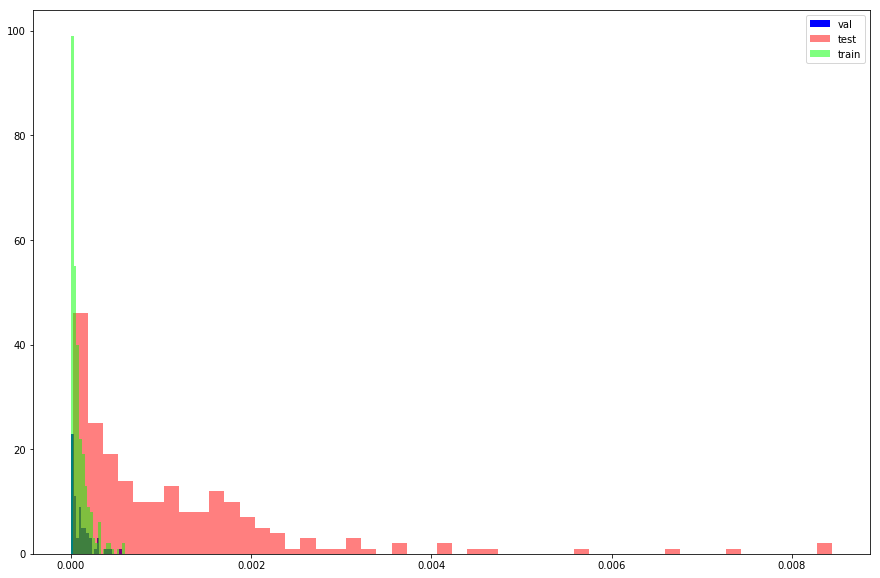

In [256]:
y_pred_test_average = []
y_pred_val_average = []
y_pred_train_average = []


for model in models:
    y_val_pred = model.predict(x_val)
    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    y_pred_test_average.append(y_test_pred)
    y_pred_val_average.append(y_val_pred)
    y_pred_train_average.append(y_train_pred)


y_pred_test_var = np.var(y_pred_test_average, axis=0)
y_pred_val_var = np.var(y_pred_val_average, axis=0)
y_pred_train_var = np.var(y_pred_train_average, axis=0)


plt.figure(figsize=(15, 10))
plt.hist(y_pred_val_var.flatten(), color='b',  bins=20, label='val')
plt.hist(y_pred_test_var.flatten(), ls='dotted', lw=3, fc=(1, 0, 0, 0.5), bins=50, label='test')
plt.hist(y_pred_train_var.flatten(), ls='dotted', lw=4, fc=(0, 1, 0, 0.5), bins=20, label='train')
plt.legend()
# plt.axis('equal')
# plt.xlim(plt.xlim())
# plt.ylim(plt.ylim())
plt.show()

Done!